## Исследование компьютерных игр

#### Описание проекта
Исследуется интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
- Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
- Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

#### Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Шаг 1. Откройте файл с данными и изучите общую информацию

Произведем импорт необходимых нам библиотек.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

Сохраним файл с данными в переменную. И посмотрим общий вид заданной таблицы.

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посмотрим общую информацию таблицы, какие в ней присутствуют колонки и с какими типами данных.

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Нашему вниманию представлена таблица с информацией о играх, проданных в интернет-магазине "Стримчик". В том числе информация о играх и информация о продажах этих игр, в какой части света они были проданы, и за сколько.

В таблице содержатся пропуски. В названии и жанре присутствуют два пропуска. Есть подозрения, что это пропуски в одинаковых строках и можно попробовать изучить информацию в интернете и заполнить пропуски достоверными данными. Пропуски в годе релиза можно было бы тоже заменить подобным образом, но их слишком много, посмотрим на дополнительные данные, может быть их можно заполнить с помощью другой информации из таблицы. Ну и для пропусков в столбцах с рейтингом и оценками нет очевидного решения, посмотрим в дальнейшем как можно их заполнить и нужно ли.


### Шаг 2. Подготовка данных.

По заданию, первым делом мы приведем названия всех колонок к нижнему регистру.

In [4]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Посмотрим сколько пропусков есть с толбцах и попробуем их устранить, при необходимости.

In [5]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски в столбце год релиза можно заполнить таким же годом, что у такой же игры в списке, если она есть еще одна.

Для этого создадим новый дф, который будет содержать только название и релиз игры. Так как релиз на все платформы происходим в один год, то удалим из нового дф все дубликаты и у нас останется только название и год релиза.


In [6]:
release_of_game = games[['name', 'year_of_release']]

In [7]:
release_of_game = release_of_game.dropna()
release_of_game = release_of_game.drop_duplicates().reset_index(drop=True)
release_of_game['year_of_release'] = release_of_game['year_of_release'].astype('int')

In [8]:
games['year_of_release'] = games['year_of_release'].fillna(0)

In [9]:
games['year_of_release'].isna().sum()

0

In [10]:
games['year_of_release'] = games['year_of_release'].astype('int')

Для того, чтобы заменить год выпуска напишем функцию. А чтобы проверить ее работувыведем выборку до и после применения функции.

In [11]:
games.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Суть функции заключается в том, что мы будем находить когда год выпуска отсутсвует в главном дф, а потом будет сравнивать с тем, который мы сами сделали. Он сравнит имена и выведет в главный дф год выпуска игры из дф release_of_game. Он может не найти это сравнение и останутся пропуски. Так как пропущенных данных немного, а тип столбца int, для дальнейших расчетов нам будет удобнее заменить пропуски на медиану сотлбца, это не изменит основных, общих расчетов, но также столбец будет сохранять тип int.

In [12]:
games['year_of_release'].median()

2007.0

In [13]:
def year_of_game(games):
    if games['year_of_release'] == 0:
        games_name = games['name']
        line = release_of_game.loc[release_of_game['name'] == games_name]['year_of_release'].reset_index(drop=True)
        try:
            return line[0]
        except:
            return 2007
    else:
        return games['year_of_release']
        
    
games['year_of_release'] = games.apply(year_of_game, axis=1)

Сначала посмотрим как заменились значения на определенной игре.

In [14]:
games.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


In [15]:
games['year_of_release'].value_counts()

2008    1441
2009    1430
2007    1348
2010    1269
2011    1153
2006    1019
2005     947
2002     845
2003     783
2004     764
2012     662
2015     606
2014     581
2013     548
2016     502
2001     486
1998     380
2000     351
1999     339
1997     289
1996     263
1995     219
1994     122
1993      62
1981      46
1992      43
1991      42
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64

Мы видим,что 146 значений все-таки не получилось заменить. Для статистики 146 не так уж и много. Оставим все как есть, так как в нашем дф нет таких же игр, содержащих год выпуска.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Хорошо.

Посмотрим на игры, которые содержат пропуски в столбце жанра. Для упрощения логического условия, заменим пропущенные значения на пробел.

In [16]:
games['genre'] = games['genre'].fillna('-')

И выведем строки, с пропущенными жанрами.

In [17]:
games.query('genre == "-"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,-,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,-,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Мы видим, что строки с пропущенными жанрами это те же строки, в которых пропущено и название. Посмотрев по дате релиза и по платформе Sega Mega Drive(Genesis), мы обнаружили множество различных игр, а условий для поиска у нас слишком мало, поэтому, мы будем игнорировать эти строки, а пропущенные значения заменим на пробел, чтобы они своими пропущенными значениями не препятствовали дальнейшему анализу.

In [18]:
games['name'] = games['name'].fillna('-')
games['genre'] = games['genre'].fillna('-')

Дальше посмотрим пропущенные значения в столбце с рейтингом. 

Для начала определим, какие рейтинги вообще существуют.

In [19]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

In [20]:
games['rating'].isna().sum()

6766

В этом столбце очень много пропущенных значений. Так как это показатель рейтинга, можем предположить, что у очень старых игр возрастного рейтинга, как такового, не было, а значит и интернет- магазин не мог заполнить этот параметр. Мы оставим этот столбец так как есть, потому, что не знаем точно какими параметрами можно заполнить эти пропущенные значения.

Остались пропущенные значения в столбцах с оценкой. Посмотрим какие категории оценок присутствуют у пользователей и у критиков.

In [21]:
games['critic_score'].value_counts().head()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
Name: critic_score, dtype: int64

In [76]:
games['user_score'].value_counts().head()

7.8    388
8.2    337
8.0    333
7.5    293
8.3    292
Name: user_score, dtype: int64

Мы видим, что шкала оценок у критиков и игроков разная. У критиков это стобальная шкала, а у игроков десятибальная. Также мы видим, что у оценок игроков есть такой параметр, как 'tbd'. Она расшифровывается, как To Be Determined, то есть "Будет определено". Видимо этот параметр стоит у новых игр, у которых рейтинг еще не подсчитан на данный момент. Заменим tbd на None, чтобы нам в дальнейшем не препятствовал tbd в анализе.

In [23]:
games['user_score'] = games['user_score'].replace('tbd', None)

In [73]:
games['user_score'].value_counts().head()

7.8    388
8.2    337
8.0    333
7.5    293
8.3    292
Name: user_score, dtype: int64

С помощью метода describe() посмотрим какие значения содержат столбцы.

In [26]:
games['critic_score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [72]:
games['user_score'].describe()

count    8760.000000
mean        7.099749
std         1.520065
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

На данном этапе мы произвели все необходимые замены типов данных, а также замену пропущенных значений.

Следующим по заданию необходимо посчитать суммарное значение всех продаж. Создадим новый столбец, назовем его 'total_sales' и произведем подсчет.

In [28]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [29]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


На этом этапе мы заканчиваем подготовку данных и приступаем к исследовательскому анализу данных.

Посмотрим результат наших операций.

In [77]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         8760 non-null float64
rating             9949 non-null object
total_sales        16715 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


### Шаг 3. Исследовательский анализ данных

#### 3.1. Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Посмотрим какие у нас в списке есть годы выпусков.

In [30]:
years = games.groupby('year_of_release').agg({'total_sales':'count'})

Построим по этим данным диаграмму размаха. По ней мы сможем проанализировать данные по годам..

In [31]:
years.describe()

,total_sales
count,37.000000
mean,451.756757
std,462.956106
min,9.000000
25%,36.000000
50%,339.000000
75%,764.000000
max,1441.000000


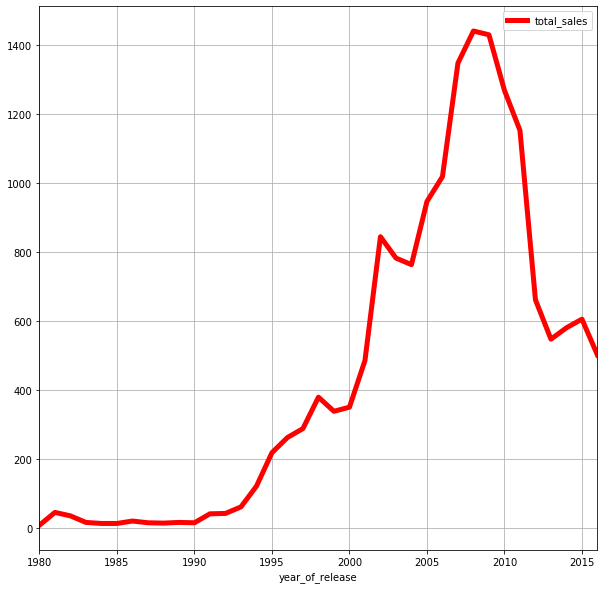

In [32]:
years.plot(grid=True, figsize=(10,10), label = 'Количество игр в году', linewidth=5, color= 'r')
plt.legend()

На данной диаграмме мы можем увидеть какое количество игр выпустилось в год. На диаграмме размаха отсутствуют точки, которые указывают на выбросы. Мы видим, что количество игр в год варьировалось. Иногда оно увеличивалось до >1400, но мы видим, что медианное значение 314, а 75% из всех лет в нашем списке не превышали значение 738 игр. А так как максимальное значение достигает 1441, можно сделать вывод, что с таким большим количеством игр эти года были очень успешны на запуски.

По графику видим, что в 2000-х количество игр возрастает в разы. Это связано с тем, что ПК стали доступнее и игры получили свое распространение в общественности. Потом, примерно в 2008 году началось падение продаж. Возможно, это связано с тем, что люди начали сами скачивать из интернета пиратские игры, которые не требуют покупки. Примерно в 2013 они пытались вырасти, но потом все равно продолжалось падение. Людям гораздо проще и дешевле просто скачать.

Начиная с 1980 по 1993 года мы видим, что игр выпускалось мало и казалось бы на какой либо анализ они повлиять не должны, но мы понимаем, что сколько игр выпускалось в эти годы вовсе не показатель того, что эти игры не были успешными и прибыльными. Может быть одна игра в каком-нибудь 1997 была по выручке превышающая 10 игр в 2010. Необходимо далее рассмотреть и иные параметры.

Так как нам нужен прогноз на 2017 год, то нам буду актуальны данные, начиная с 2008 года. Так как именно тогда началось резкое падение. И значит, нам интересна именно прогрессия на падение.


Оставим у графика только нужную нам часть.

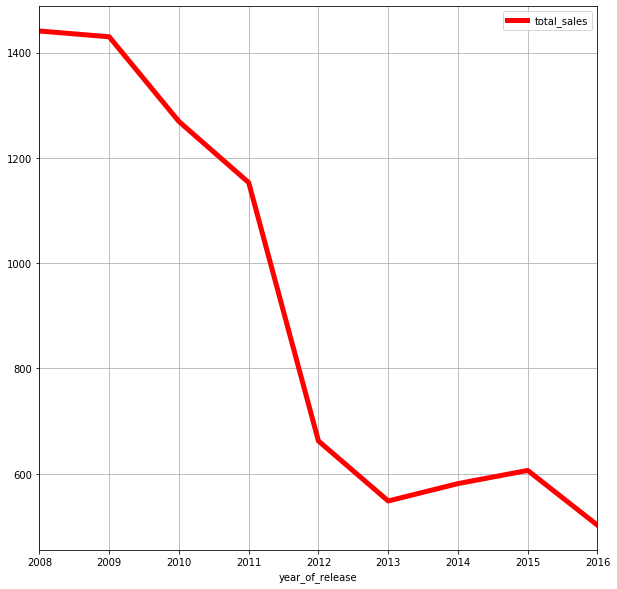

In [33]:
years.query('year_of_release >= 2008').plot(grid=True, figsize=(10,10), label = 'Количество игр в году', linewidth=5, color= 'r')
plt.legend()

#### 3.2. Как менялись продажи по платформам. Выбор платформ с наибольшими суммарными продажами и построение распределения по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Чтобы определить продажи по платформам, сгруппируем платформы и суммируем по каждой платформе общие продажи.

In [34]:
platform_sale = games.groupby('platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False)

Чтобы углубиться в изучение составим диаграмму размаха.

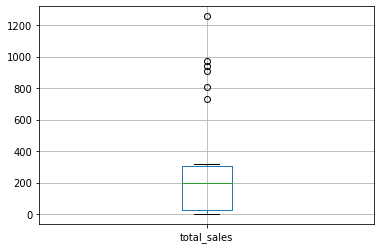

In [35]:
platform_sale.boxplot()

На ней мы видим, что большинство продаж находится до отметки 317, а все, что дальше- это выбросы. Но в нашем случае, выбросы это и есть "максимально продающиеся" платформы во все года.

#### Этими платформами оказались:
- PS2	(1255.77)
- X360	(971.42)
- PS3	(939.65)
- Wii	(907.51)
- DS	(806.12)
- PS	(730.86)

Это очень знамениты игровые платформы. В основном это, конечно PlayStation, но также присутствуют и XBOX, Wii и Nintendo.

Так как самих платформ очень много, то мы возьмем эти 6 самых продающихся и будем по ним смотреть распределение по годам.

Сначала создадим дф для всех платформ, а потом возьмем только те колонки, что нам нужны. К самым продающимся в эту таблицу добавим и те платформы, которые может приносят и не такие большие продажи, но также пользуются популярностью.

In [36]:
sales_in_year = games.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

In [37]:
sales_top = sales_in_year[['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'PSP', 'PC', 'XOne']]

В этой сводной таблице мы можем видеть срок жизни самых продающихся игровых платформ. Мы видим, что на 2016 год некоторые еще продолжают выпускаться и сохранять продажи. Это XBOX360, Wii и PS3. Соответственно, их можно включить в план продаж, а также новые платформы, которые относительно недавно выпустились.

Построим график, на котором будут построены распределения продаж каждой из топовых платформ на определенных участках времени.

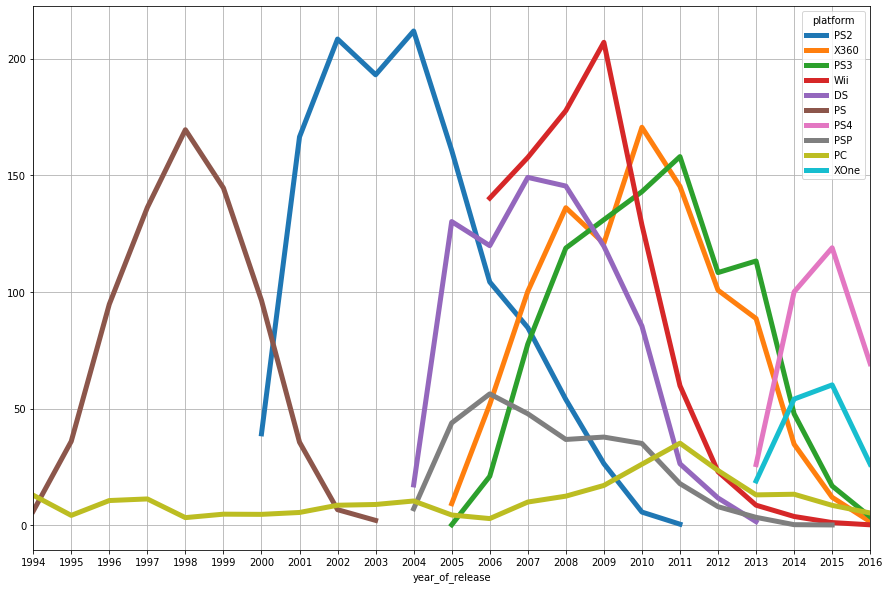

In [70]:
sales_top.plot(grid=True, figsize=(15,10), linewidth=5)
axes = plt.gca()
axes.set_xlim([1994,2016])
import math
x = [1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
xint = range(min(x), math.ceil(max(x))+1)
plt.xticks(xint)
plt.show()

Мы видим, что платформа Wii начала свой первый год с высоких продаж. Наверное, у нее перед выходом была проведена блестящая рекламная компания.

На примере PlayStation и трех их ее консолей, а именно PS, PS2 и PSP мы видим, что срок актуальности консоли примерно 10-12 лет. Причем зачастую, когда выходит новая консоль предыдущая еще не утратила свою актуальность. Поэтому PS и XBOX после выхода новой продукции все еще поддерживают и выпускают игры для предыдущей.

Так мы видим, что игры для X360 и PS3 уже продаются 12 лет и продажи почти упали в 0. Скорее всего в следующем году игры для данных консолей не будут иметь большой актуальности.

### Возьмем данные за соответствующий актуальный период (2004-2016). Не будем учитывать в работе данные за предыдущие годы.

#### 3.4. Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

Сначала сделаем выборку по дате, чтобы не учитывать в работе более ранние игры.

In [39]:
games_new = games.query('year_of_release >= 2004')

Сделаем сводную таблицу, в которой буду годы релизов игр исключительно с 2004 года. И значениями в ней будут общие продажи по платформам.

In [40]:
games_total = games_new.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

Так как мы видим, что некоторые колонки содержат просто одно значение и то в начале списка, или игры на этой платформе уже перестали выпускать в начале периода, удалим эти столбцы, чтобы они не мешали изучать актуальные данные.

In [41]:
games_total = games_total.drop(['2600', 'DC', 'GB', 'GBA', 'GC', 'N64', 'PS', 'PS2', 'XB', 'DS', 'PSP'], axis='columns')

Создадим график, на котором будет показаны полные продажи каждой платформы, чтобы увидеть на сравнении.

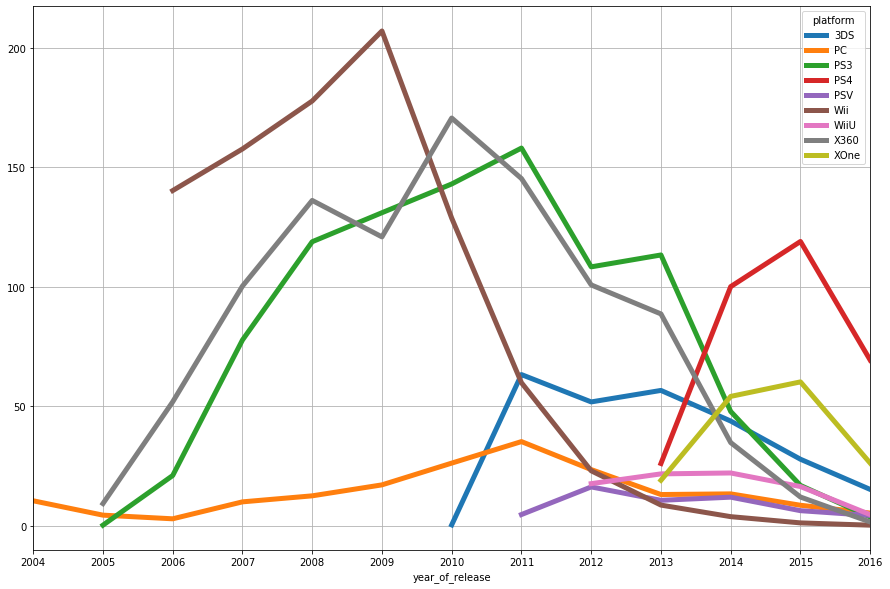

In [71]:
games_total.plot(grid=True, figsize=(15,10), linewidth=5)
axes = plt.gca()
import math
x = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
xint = range(min(x), math.ceil(max(x))+1)
plt.xticks(xint)
plt.show()

По графику мы видим, что продажи полностью не упадут в следующем году как минимум у платформ XOne, PS4 и 3DS. Значит игры на этих платформах точно необходимо будет иметь в виду, при планировании рекламных кампаний.

#### Так как нам нужен план продаж, определимся, игры для каких платформ стоит приобретать в следующем году:
- на ПК продажи хоть и не большие, но они были на протяжении всего времени и оставались актуальными. Наверняка и в следующем году актуальными они будут.
- PS4, XOne и 3DS совсем еще недавно появились и наверняка ее тоже стоит иметь ввиду, чтобы проводить рекламную кампанию. Хоть у них продажи и падают, но нам понятно,  что у всех игр падают продажи.
- по графику видим, что продажи до сих пор сохраняются у PS3, X360, Wii, но скорее всего в следующем году они будут уже не актуальны.

Можно сделать вывод, что потенциально прибыльные платформы это  PS4, XOne, WiiU 3DS и PC, потому, что игры на компьютер актуальны перманентно.

#### 3.5. Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах?

Чтобы сделать выборку по нужным нам прибыльным платформам - сделаем отдельный словарь с их названиями, чтобы можно было применить условие нахождения нужной платформы в словаре. И в итоге в дф останутся только нужные нам платформы для группировки.

In [43]:
top_platform = ['PS4', 'XOne', '3DS', 'PC', 'WiiU']

In [44]:
name_platform = (games_new
                 .query('platform in @top_platform')
                 .groupby(['name', 'platform']).agg({'total_sales':'sum'})
                )

И по полученным данным построим диаграмму размаха. Установим ограничение по оси у, потому, что основная масса значений находится близко к 0 и не совсем удачно получается ее рассмотреть. А все что находится выше значения 4 по оси у - лишь выбросы.

(0, 1.75)

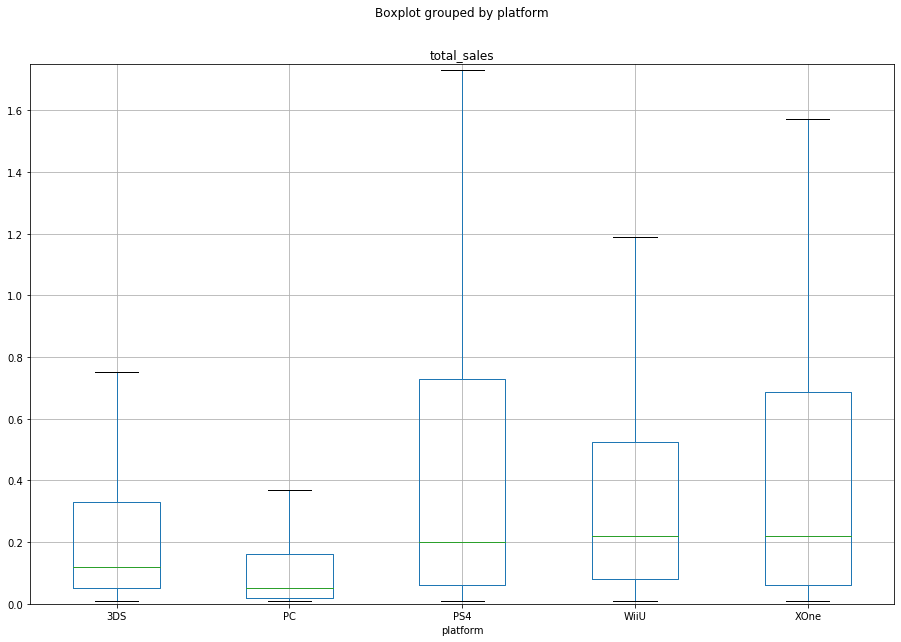

In [45]:
name_platform.boxplot('total_sales', by='platform', figsize=(15,10), showfliers=False)
plt.ylim(0,1.75)

Нам становится понятно, что продажи на всех платформах сильно варьируются:
- Максимальные продажи наблюдаются на платформе PS4, но при этом средние продажи они немного уступают XOne. 
- WiiU находится на третьем месте по максимальным продажам, но ее медиана находится на одном уровне с PS4 и XOne.
- На платформе 3DS максимальная продажа находится на уровне третьего квартиля PS4 и XOne.
- Самые минимальные продажи и общие и средние на ПК, но при этом они самые стабильные, как мы видели из предыдущих графиков.
- Все диаграммы скошенны вправо, значит распределение не симметричное.

Можно сделать вывод, что предпочтительнее вкладываться в рекламу на PS4, чем на XOne, потому что с PS4 продажи больше. У остальных платформ продажи еще меньше.
Также необходимо вкладываться в рекламу игр на ПК, потому, как гораздо больше людей играют на компьютере, чем на консоли. Так можно будет поднять продажи на игры на ПК.

#### 3.6. Посмотрим, как влияют на продажи внутри платформы PS4 отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. И соотнесем выводы с продажами на других популярных платформах.

Сделаем группировку по названию игры, платформе и отзывам. Выведем общие продажы для данной игры.

In [46]:
name_score = (games_new
              .query('platform == "PS4"')
              .groupby(['name', 'platform', 'critic_score', 'user_score']).agg({'total_sales':'sum'})
              .reset_index()
             )

Посмотрим на корреляцию оценок критиков, пользователей и объемом продаж.

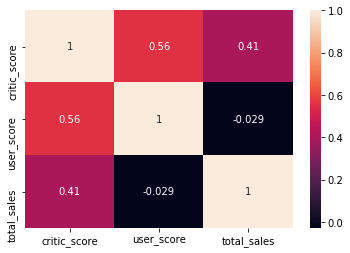

In [47]:
sns.heatmap(name_score.corr(), annot = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76ce7bc7d0>,
      dtype=object)

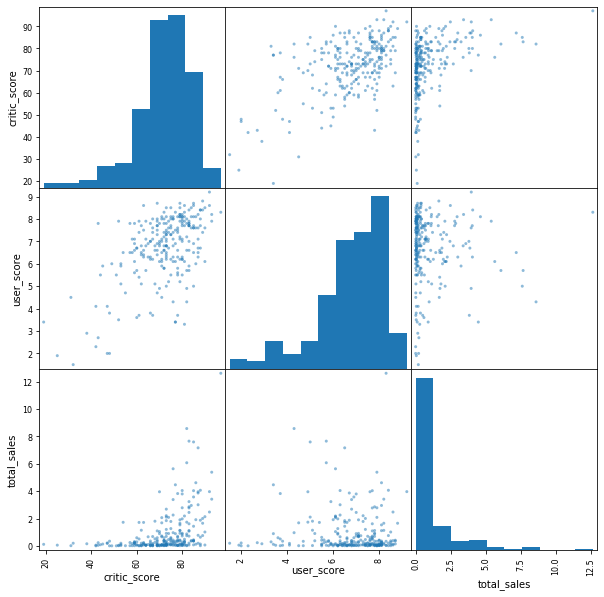

In [48]:
pd.plotting.scatter_matrix(name_score, figsize=(10,10))

Из попарных диаграмм и корреляции мы видим, что зависимость оценки пользователя и продажами - обратная, что странно. Но само значение настолько мало, что будто бы и нет никакой зависимости. Больше всего зависимость у оценки критиков и пользователей. Видимо пользователи зачастую выставляют оценки, ориентируясь на оценки критиков. А вот с продажами все ясно, чем выше у игры оценка от критиков, тем больше её покупают.

Теперь сравним выводы из анализа одной платформы с анализом всех популярных платформ.

In [49]:
top_score = (games_new
              .query('platform in @top_platform')
              .groupby(['name', 'platform', 'critic_score', 'user_score']).agg({'total_sales':'sum'})
              .reset_index()
             )

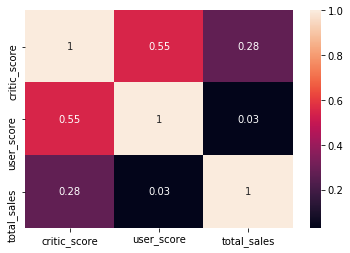

In [50]:
sns.heatmap(top_score.corr(), annot = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76cc9d4610>,
      dtype=object)

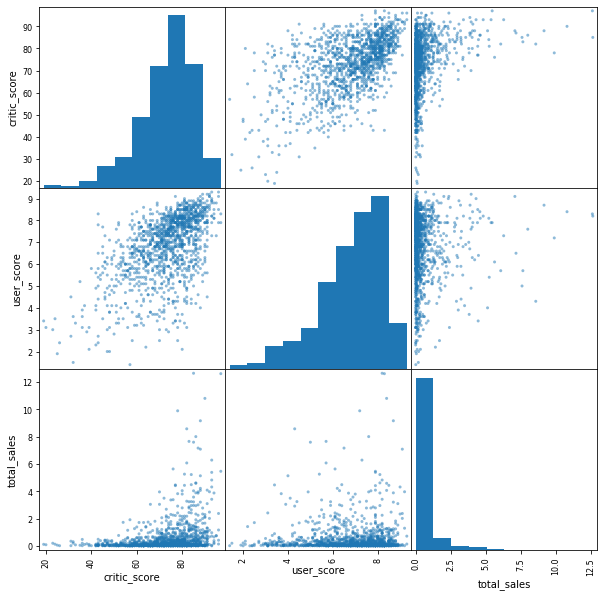

In [51]:
pd.plotting.scatter_matrix(top_score, figsize=(10,10))

Корреляция примерно такая же, как и на самой топовой платформе. Продажи сильнее зависят от оценки критиков, и почти не зависят от оценки пользователей.

Из анализа делаем вывод такой: выбираем в каких играх вкладывать деньги в рекламу в зависимости от оценки критиков. Если их оценка большая, то игру будут покупать.

#### 3.7. Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [52]:
genre_sales = (games_new
               .query('platform in @top_platform')
               .groupby('genre').agg({'total_sales':'sum'})
                )
genre_sales

,total_sales
genre,
Action,237.66
Adventure,18.05
Fighting,28.20
Misc,40.26
Platform,63.11
Puzzle,7.82
Racing,48.72
Role-Playing,171.15
Shooter,192.10


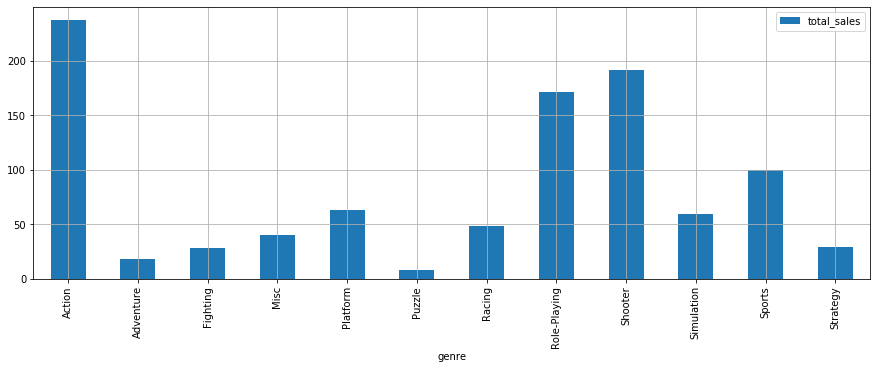

In [53]:
genre_sales.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5)

Мы можем видеть, что разница между продающимися жанрами и не продающимися - колоссальная. Разница в продажах между минимальным и максимальным - более чем в 200 млн. Самым продающимся оказался жанра 'экшен', а самым не продающимся - 'головоломки'. Это можно понять, многие играют, чтобы расслабиться и чтобы было интересно, а головоломки, зачастую не так интересно, как различные "бегалки" и "стрелялки".

#### Мы можем выделить три жанра, которые больше всего выделяются:
- Action (218.59)
- Role-Playing (168.26)
- Shooter (186.09)

Это как раз те жанры, в которых большую роль играет динамика, стратегия и полное вовлечение в игру. Получается, что в основном делаем вклады в рекламную кампанию по этим жанрам, так как они явно выделяются из общей картины.

### Шаг 4. Составим портрет пользователя каждого региона

#### Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Различия в долях продаж.
- Самые популярные жанры (топ-5). Разница в предпочтениях.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### 4.1. Самые популярные платформы (топ-5) в каждом регионе.

In [54]:
top_regions = (games_new
               .query('platform in @top_platform')
               .groupby('platform').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum'})
              )
top_regions

,na_sales,eu_sales,jp_sales
platform,,,
3DS,83.49,61.48,100.65
PC,49.55,112.60,0.08
PS4,108.74,141.09,15.96
WiiU,38.10,25.13,13.01
XOne,93.12,51.59,0.34


Text(0.5, 1.0, 'Продажи по платформам в Северной Америке')

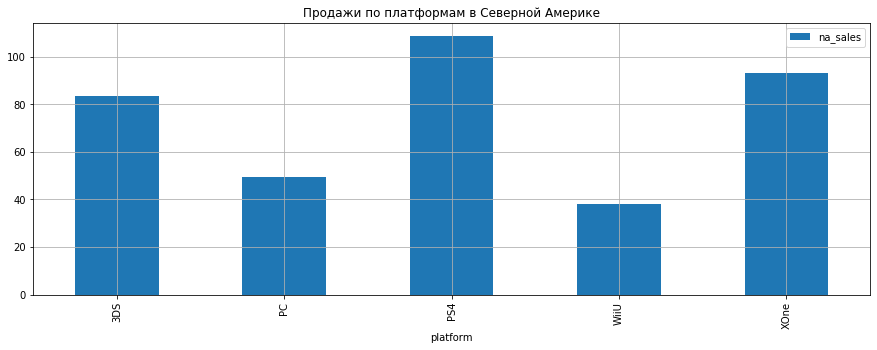

In [55]:
top_regions.plot(kind='bar', y='na_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по платформам в Северной Америке')

Text(0.5, 1.0, 'Продажи по платформам в Европе')

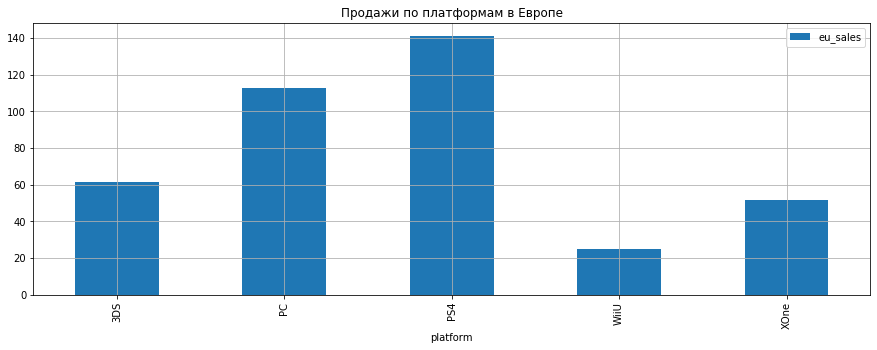

In [56]:
top_regions.plot(kind='bar', y='eu_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по платформам в Европе')

Text(0.5, 1.0, 'Продажи по платформам в Японии')

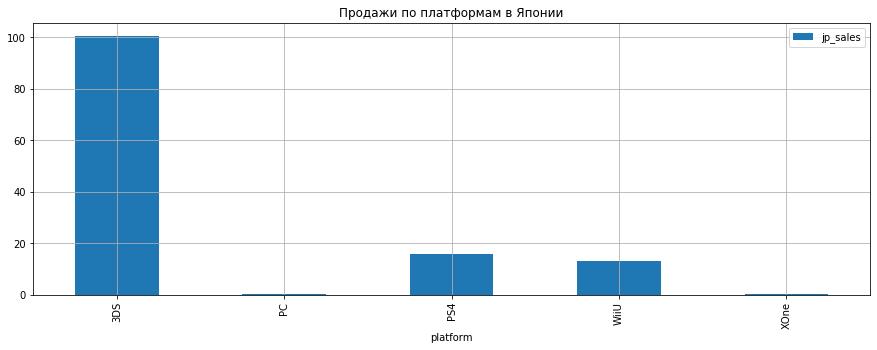

In [57]:
top_regions.plot(kind='bar', y='jp_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по платформам в Японии')

Благодаря графикам мы видим самые популярные платформы в разных регионах.

#### Топ-5 для стран Северной Америки:      
1. PS4 (108.74)  
2. XOne (93.12)  
3. 3DS (83.49)
4. PC (49.55) 
5. WiiU (38.10)

#### Топ-5 для стран Европы:
1. PS4 (141.09)	
2. PC (112.60)
3. 3DS (83.49)	
4. XOne (93.12)	
5. WiiU (25.13)

#### Топ-5 для Японии:
1. 3DS (100.65)		
2. PS4 (15.96)
3. WiiU (13.01)
4. XOne (0.34)	
5. PC (0.08)	

В странах Европы все игры на новые платформы продаются лучше. Так как в этом регионе продажи чуть больше, чем в Северной Америке, то на него нужно больше затрат в плане рекламы, так, как в этом регионе продажи больше, а значит и охват больше тоже. 

Самая продающаяся платформа во всех регионах, кроме Японии это PS4, значит и максимальная реклама должна пойти на нее. Но при этом в Японии самая популярная это 3DS Nintendo, значит в Японии максимум рекламы будет на нее.

А отдельно по регионам вклады в рекламу следует осуществлять в соответствии с топ-5, потому, как они явно отражают наличие у игроков определенных консолей. А так как консоли новые, мало людей будут их так быстро менять.

#### 4.2. Самые популярные жанры (топ-5). Разница в предпочтениях.

In [58]:
top_genres = games_new.groupby('genre').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum'})
top_genres

,na_sales,eu_sales,jp_sales
genre,,,
Action,633.61,396.04,114.50
Adventure,75.26,42.40,31.56
Fighting,117.31,52.50,33.22
Misc,335.22,178.14,76.01
Platform,177.09,99.42,42.55
Puzzle,54.60,35.52,21.82
Racing,187.26,142.83,19.64
Role-Playing,234.18,132.72,195.11
Shooter,435.96,263.39,21.40


Text(0.5, 1.0, 'Продажи по жанрам в странах Северной Америки')

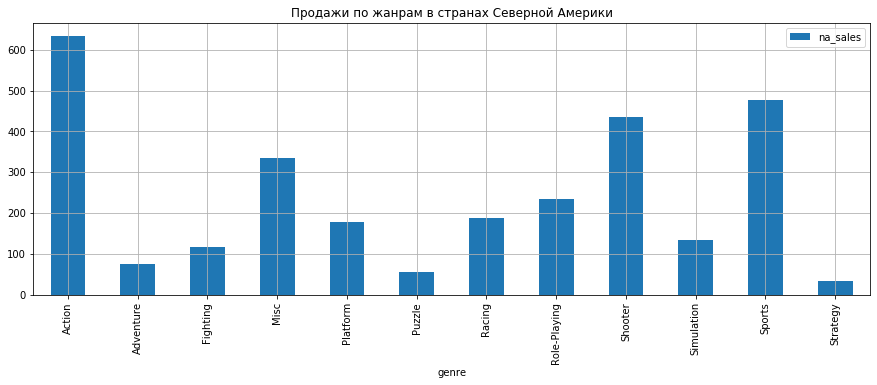

In [59]:
top_genres.plot(kind='bar', y='na_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по жанрам в странах Северной Америки')

Text(0.5, 1.0, 'Продажи по жанрам в странах Европы')

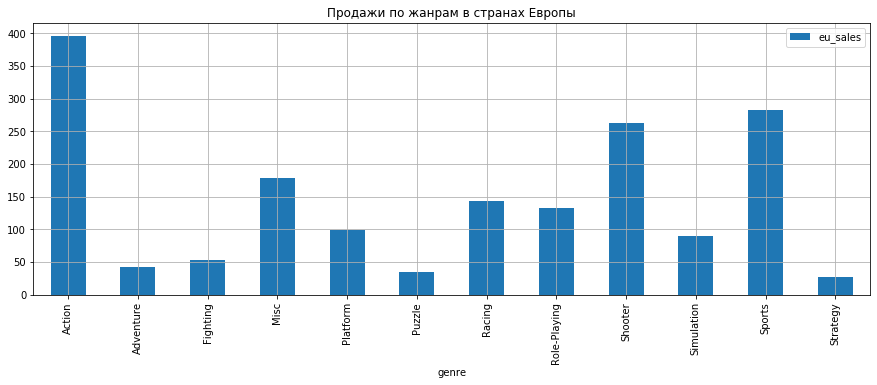

In [60]:
top_genres.plot(kind='bar', y='eu_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по жанрам в странах Европы')

Text(0.5, 1.0, 'Продажи по жанрам в Японии')

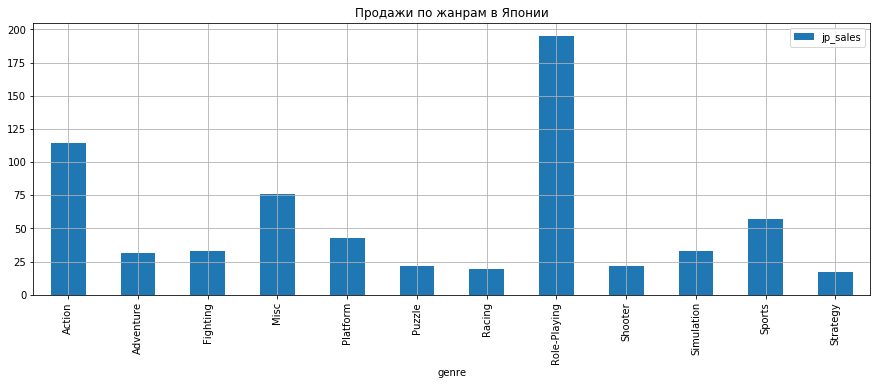

In [61]:
top_genres.plot(kind='bar', y='jp_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по жанрам в Японии')

#### Топ-5 популярных жанров в странах Северной Америки:
1. Action
2. Sports
3. Shooter
4. Misc
5. Racing

#### Топ-5 популярных жанров в странах Европы:
1. Action
2. Sports
3. Shooter
4. Misc
5. Racing

#### Топ-5 популярных жанров в Японии:
1. Role-Playing
2. Action
3. Misc
4. Sports
5. Platform

Популярные жанры во всех странах кроме Японии оказали одинаковыми. Конечно, продажи по жанрам отличаются, но в целом именно процентное соотношение одинаковое. В Японии же оказались популярными ролевые игры и бродилки.

#### 4.3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [62]:
rating_genres = games_new.groupby('rating').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum'})
rating_genres

,na_sales,eu_sales,jp_sales
rating,,,
AO,1.26,0.61,0.00
E,980.26,551.70,159.37
E10+,353.06,187.92,40.03
EC,1.53,0.11,0.00
M,653.79,431.96,49.21
RP,0.00,0.08,0.00
T,539.11,296.19,99.98


#### Для начала дадим расшифрровку каждому рейтингу:
- «AO» («Adults Only 18+») — «Только для взрослых»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «EC» («Early childhood») — «Для детей младшего возраста»
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «M» («Mature») — «Для взрослых»
- «T» («Teen») — «Подросткам»

Text(0.5, 1.0, 'Продажи по рейтингу в странах Северной Америки')

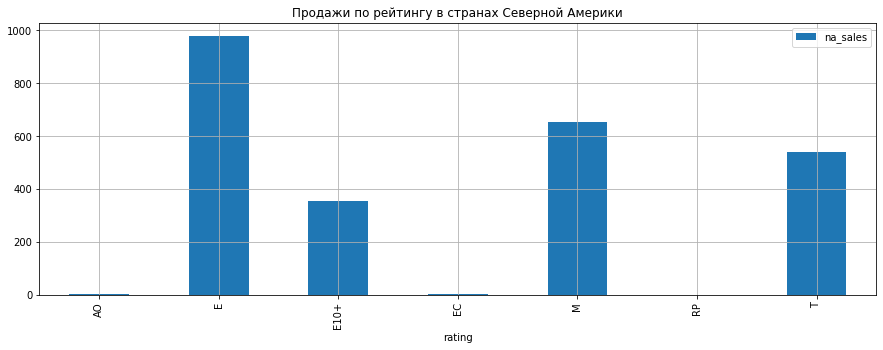

In [63]:
rating_genres.plot(kind='bar', y='na_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по рейтингу в странах Северной Америки')

Text(0.5, 1.0, 'Продажи по рейтингу в странах Европы')

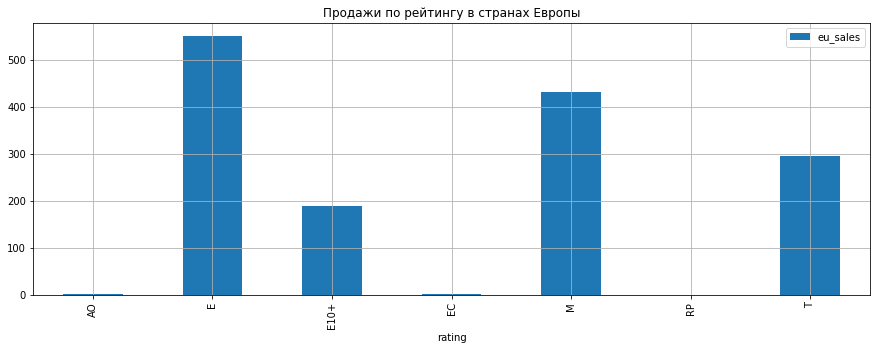

In [64]:
rating_genres.plot(kind='bar', y='eu_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по рейтингу в странах Европы')

Text(0.5, 1.0, 'Продажи по рейтингу в Японии')

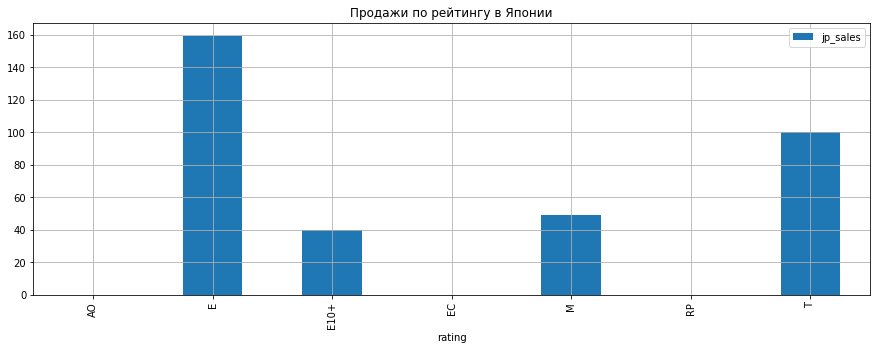

In [65]:
rating_genres.plot(kind='bar', y='jp_sales', grid=True, figsize=(15,5), linewidth=5)
plt.title('Продажи по рейтингу в Японии')

Везде лидируют игры, в которые можно играть всем. Это логично, нет ограничений - больше людей смогут играть. На втором месте во всех регионах, кроме Японии находятся игры с рейтингом для взрослых. Также в лидерах находится рейтинг для подростков. Ну и игры для совсем маленьких и только для взрослых имеют очень низкие продажи, потому, как это только для одного слоя населения. При этом игры с рейтингом М в Японии тоже имеют маленькие продажи.

Составим портрет пользователя для каждого региона. За основу будем брать максимальные продажи на графике, ведь максимальные продажи означают, что это большее количество человек.

#### Портрет пользователя региона Северная Америка:
- предпочитает консоли PS4 и XOne;
- выбирает жанры Action, Sports и Shooter;
- отдает предпочтение фильмам, которые может смотреть каждый, но также иногда смотрит фильмы для взрослых и для подростков.

#### Портрет пользователя региона Европа:
- предпочитает консоли PS4 и персональному компьютеру;
- выбирает жанры Action, Sports и Shooter;
- отдает предпочтение фильмам, которые может смотреть каждый.

#### Портрет пользователя Японии:
- выбирает платформу Nintendo 3DS;
- выбирает жанры Role-Playing и Action;
- отдает предпочтение фильмам, которые может смотреть каждый, и не фильмы для взрослых.

Из всего мы видим, что портрет пользователя Америки и Европы сильно отличается от пользователя в Японии. Но это понятно, так как Япония это восточная страна, со своим менталитетом и своими обычаями.


### Шаг 5. Проверьте гипотезы

#### 5.1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

#### Зададим две гипотезы:
В нулевой гипотезе всегда отталкиваемся от того, что данные равны.
1. Нулевая гипотеза - cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Альтернативная гипотеза - cредние пользовательские рейтинги платформ Xbox One и PC различаются.

In [66]:
xone_rating = games.query('platform == "XOne"')['user_score'].dropna()
pc_rating = games.query('platform == "PC"')['user_score'].dropna()
alpha = 0.05
results = st.ttest_ind(xone_rating, pc_rating, equal_var = False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.614515353469983e-06
Отвергаем нулевую гипотезу


Так как мы отвергаем нулевую гипотезу, которая говорит о том, что данные равны. Можно сделать вывод, что данная нам гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые **неверна**.

#### 5.2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

#### Зададим две гипотезы:
В нулевой гипотезе всегда отталкиваемся от того, что данные равны.
1. Нулевая гипотеза - средние пользовательские рейтинги жанров Action и Sports равны.
2. Альтернативная гипотеза - средние пользовательские рейтинги жанров Action и Sports различаются.

In [67]:
action_rating = games.query('genre == "Action"')['user_score'].dropna()
sports = games.query('genre == "Sports"')['user_score'].dropna()
alpha = 0.05
results = st.ttest_ind(action_rating, sports, equal_var = False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.08098580953332642
Не получилось отвергнуть нулевую гипотезу


Так как мы отвергаем нулевую гипотезу, которая говорит о том, что данные равны. Можно сделать вывод, что данная нам гипотеза о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные **верна**.

### Шаг 6. Общий вывод.

Для распределения рекламного бюджета на 2017 год, интернет- магазин "Стримчик" хотел выявить определяющие успешность игры закономерности. Чтобы сделать ставку на потенциально популярный продукт.

По графикам мы  увидели, что в 2000-х количество игр возрастает в разы. Это связано с тем, что ПК стали доступнее и игры получили свое распространение в общественности. Потом, примерно в 2008 году началось падение продаж. Возможно, это связано с тем, что люди начали сами скачивать из интернета пиратские игры, которые не требуют покупки. Примерно в 2013 они пытались вырасти, но потом все равно продолжалось падение. Людям гораздо проще и дешевле просто скачать.

- Для того, чтобы данные были актуальными, мы определили, что срок жизни платформы 10-12 лет. Устранив все лишние и не актуальные данные мы выбрали те платформы, на которые можно сделать ставку в 2017 году. Ими оказались 'PS4', 'XOne', '3DS', 'PC', 'WiiU'.

- Мы увидели, что платформа Wii начала свой первый год с высоких продаж. Наверное, у нее перед выходом была проведена блестящая рекламная компания и она была очень популярна.

Нам становится понятно, что продажи на всех платформах сильно варьируются:

- Максимальные продажи наблюдаются на платформе PS4, но при этом средние продажи они немного уступают XOne.
- WiiU находится на третьем месте по максимальным продажам, но ее медиана находится на одном уровне с PS4 и XOne.
- На платформе 3DS максимальная продажа находится на уровне третьего квартиля PS4 и XOne.
- Самые минимальные продажи и общие и средние на ПК, но при этом они самые стабильные, как мы видели из предыдущих графиков.
- Все диаграммы скошенны вправо, значит распределение не симметричное.

Таким образом, делаем вывод, что предпочтительнее вкладываться в рекламу на PS4, чем на XOne, потому что с PS4 продажи больше. У остальных платформ продажи еще меньше. Также необходимо вкладываться в рекламу игр на ПК, потому, как гораздо больше людей играют на компьютере, чем на консоли. Так можно будет поднять продажи на игры на ПК.

#### Сделали анализ продаж по платформам и определили, что:

- В странах Европы все игры на новые платформы продаются лучше. Так как в этом регионе продажи чуть больше, чем в Северной Америке, то на него нужно больше затрат в плане рекламы, так, как в этом регионе продажи больше, а значит и охват больше тоже.

- Самая продающаяся платформа во всех регионах, кроме Японии это PS4, значит и максимальная реклама должна пойти на нее. Но при этом в Японии самая популярная это 3DS Nintendo, значит в Японии максимум рекламы будет на нее.

- Отдельно по регионам вклады в рекламу следует осуществлять в соответствии с топ-5 по платформам, потому, как они явно отражают наличие у игроков определенных консолей. А так как консоли новые, мало людей будут их так быстро менять.

Популярные жанры во всех странах кроме Японии оказали одинаковыми. Конечно, продажи по жанрам отличаются, но в целом именно процентное соотношение одинаковое. В Японии же оказались популярными ролевые игры и бродилки.

Везде лидируют игры, в которые можно играть всем. Это логично, нет ограничений - больше людей смогут играть. На втором месте во всех регионах, кроме Японии находятся игры с рейтингом для взрослых. Также в лидерах находится рейтинг для подростков. Ну и игры для совсем маленьких и только для взрослых имеют очень низкие продажи, потому, как это только для одного слоя населения. При этом игры с рейтингом М в Японии тоже имеют маленькие продажи.

Также мы составили портрет пользователей по регионам, чтобы посмотреть, чему больше отдают предпочтение игроки в зависимости от страны.

#### Портрет пользователя региона Северная Америка:
- предпочитает консоли PS4 и XOne;
- выбирает жанры Action, Sports и Shooter;
- отдает предпочтение фильмам, которые может смотреть каждый, но также иногда смотрит фильмы для взрослых и для подростков.

#### Портрет пользователя региона Европа:
- предпочитает консоли PS4 и персональному компьютеру;
- выбирает жанры Action, Sports и Shooter;
- отдает предпочтение фильмам, которые может смотреть каждый.

#### Портрет пользователя Японии:
- выбирает платформу Nintendo 3DS;
- выбирает жанры Role-Playing и Action;
- отдает предпочтение фильмам, которые может смотреть каждый, и не фильмы для взрослых.


Из всего мы видим, что портрет пользователя Америки и Европы сильно отличается от пользователя в Японии. Но это понятно, так как Япония это восточная страна, со своим менталитетом и своими обычаями.

Таким образом у нас появилась полная картина того, во что выгодней всего вкладывать рекламный бюджет в следующем 2017 году.